# Automatic Number Plate Recognition using using Contours and Convolution Neural Networks (CNN)
#### In this project notebook, we show the overall implementation of License Plate Detection using the Contour method.

The contours are a useful tool for shape analysis and object detection and recognition. Using contour detection, we can detect the borders of objects, and therefore, localize them easily. Importantly, contour detection could be the very first step for many interesting applications such as image foreground extraction, simple image segmentation, detection and recognition.

## Import the necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from sklearn.metrics import f1_score
!pip install tensorflow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers


from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


You should consider upgrading via the 'c:\users\win10\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
pwd

'C:\\Users\\WIN10\\LPD'

## Load the image
In this step, we load an image that contains a car with its license plate.

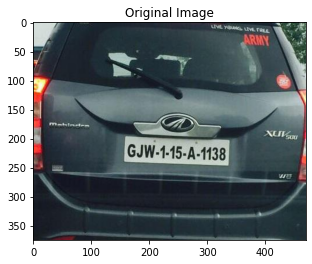

In [59]:
# Read the image file
image = cv2.imread('test_dataset/images/2.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

## Finding Contours
In this, the image is first preprocessed and then sent for finding contours.
Image preprocessing contains the following steps:
- **Resizing the image**
- **Grayscale Conversion**
- **Noise Removal**
- **Binarization**

After this, the image is ready to find contours.


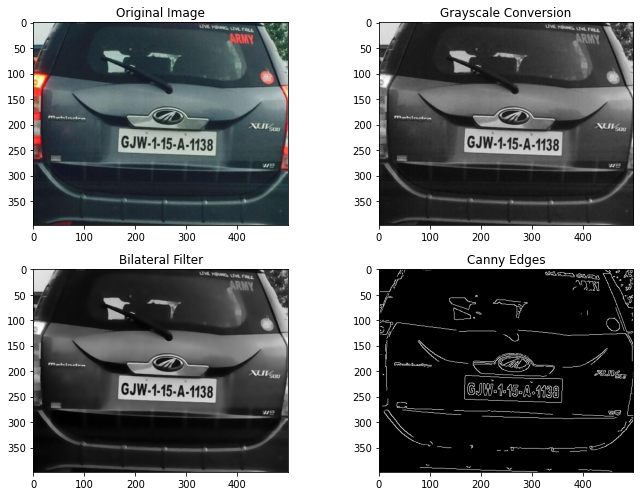

In [60]:
image = imutils.resize(image, width=500)
img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the original image
fig, ax = plt.subplots(2, 2, figsize=(10,7))
ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('Original Image')

# RGB to Gray scale conversion
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ax[0,1].imshow(gray, cmap='gray')
ax[0,1].set_title('Grayscale Conversion')

# Noise removal with iterative bilateral filter(removes noise while preserving edges)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
ax[1,0].imshow(gray, cmap='gray')
ax[1,0].set_title('Bilateral Filter')

# Find Edges of the grayscale image
edged = cv2.Canny(gray, 170, 200)
ax[1,1].imshow(edged, cmap='gray')
ax[1,1].set_title('Canny Edges')

fig.tight_layout()
plt.show()

# Find contours based on Edges
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
NumberPlateCnt = None #we currently have no Number plate contour

# loop over our contours to find the best possible approximate contour of number plate
count = 0
for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  # Select the contour with 4 corners
            NumberPlateCnt = approx #This is our approx Number Plate Contour
            x,y,w,h = cv2.boundingRect(c)
            ROI = img[y:y+h, x:x+w]
            break

if NumberPlateCnt is not None:
    # Drawing the selected contour on the original image
    cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)

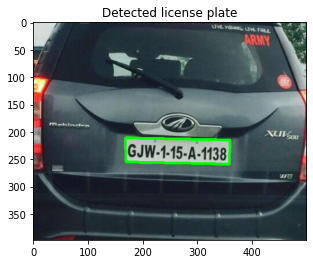

In [61]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected license plate")
plt.show()

The green bounding box shows the detected license plate.

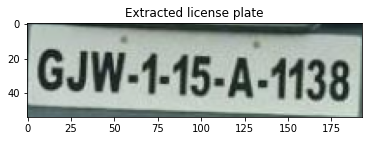

In [62]:
# Find bounding box and extract ROI
plt.imshow(ROI)
plt.title("Extracted license plate")
plt.show()

## Rotate the plate (if tilted)
This step is useful if the extracted license plate is tilted/rotated. It might arise problems in the character segmentation phase, so it is better to straighten it.

In [63]:
print(NumberPlateCnt)

[[[168 211]]

 [[169 255]]

 [[358 259]]

 [[359 215]]]


In [64]:
# Distance between (x1, y1) and (x2, y2)
def dist(x1, x2, y1, y2):
    return ((x1-x2)**2+(y1-y2)**2)**0.5

In [65]:
idx=0
m=0
# To find the index of coordinate with maximum y-coordinate
for i in range(4):
    if NumberPlateCnt[i][0][1]>m:
        idx=i
        m=NumberPlateCnt[i][0][1]

# Assign index to the previous coordinate
if idx==0:
    pin=3
else:
    pin=idx-1

# Assign index to the next coordinate
if idx==3:
    nin=0
else:
    nin=idx+1

# Find distances between the acquired coordinate and its previous and next coordinate
p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

# The coordinate that has more distance from the acquired coordinate is the required second bottom-most coordinate
if p>n:
    if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
        left=pin
        right=idx
    else:
        left=idx
        right=pin
    d=p
else:
    if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
        left=nin
        right=idx
    else:
        left=idx
        right=nin
    d=n
print(left, right)

1 2


Extract the coordinates of the bottom-most coordinates in such a way that ```(left_x, left_y)``` denote the bottom-left coordinate and ```(right_x, right_y)``` denote the bottom-right coordinate.

In [66]:
left_x=NumberPlateCnt[left][0][0]
left_y=NumberPlateCnt[left][0][1]
right_x=NumberPlateCnt[right][0][0]
right_y=NumberPlateCnt[right][0][1]
print(left_x, left_y, right_x, right_y)

169 255 358 259


For rotating the plate, we need to find the angle of rotation. This can be found out by calculating the sin of theta using the two coordinates. Theta can then be extracted by finding the inverse of sin. Image can finally be rotated by using ```cv2.getRotationMatrix2D()``` function.

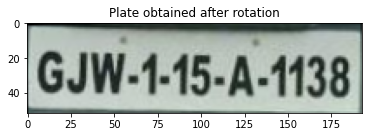

In [67]:
# Finding the angle of rotation by calculating sin of theta
opp=right_y-left_y
hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
sin=opp/hyp
theta=math.asin(sin)*57.2958

# Rotate the image according to the angle of rotation obtained
image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

# The image can be cropped after rotation( since rotated image takes much more height)
if opp>0:
    h=result.shape[0]-opp//2
else:
    h=result.shape[0]+opp//2

result=result[0:h, :]
plt.imshow(result)
plt.title("Plate obtained after rotation")
plt.show()

## Character Segmentation
Character segmentation is an operation that seeks to decompose an image of a sequence of characters into subimages of individual symbols. It is one of the decision processes in a system for optical character recognition.



In [68]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [69]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

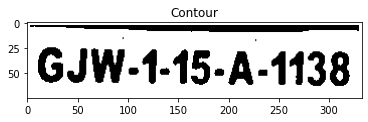

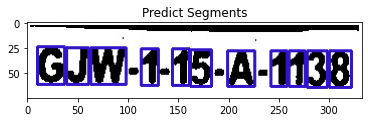

In [70]:
char=segment_characters(result)

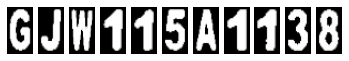

In [71]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

## Character Recognition using CNN
Since the data is all clean and ready, now it’s time do create a Neural Network that will be intelligent enough to recognize the characters after training. In this project, we used CNN model for character recognition.


In [72]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [73]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics='accuracy')

In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [75]:
batch_size = 1
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 25, verbose=1, callbacks=None)

Epoch 1/25
864/864 [==============================] - 37s 42ms/step - loss: 3.0886 - accuracy: 0.1574 - val_loss: 1.7953 - val_accuracy: 0.5046
Epoch 2/25
864/864 [==============================] - 36s 42ms/step - loss: 1.2149 - accuracy: 0.6250 - val_loss: 0.6662 - val_accuracy: 0.7870
Epoch 3/25
864/864 [==============================] - 36s 42ms/step - loss: 0.6672 - accuracy: 0.7905 - val_loss: 0.3614 - val_accuracy: 0.9074
Epoch 4/25
864/864 [==============================] - 36s 42ms/step - loss: 0.4054 - accuracy: 0.8819 - val_loss: 0.3743 - val_accuracy: 0.8889
Epoch 5/25
864/864 [==============================] - 36s 41ms/step - loss: 0.2818 - accuracy: 0.9167 - val_loss: 0.2180 - val_accuracy: 0.9259
Epoch 6/25
864/864 [==============================] - 36s 41ms/step - loss: 0.2574 - accuracy: 0.9178 - val_loss: 0.2302 - val_accuracy: 0.9306
Epoch 7/25
864/864 [==============================] - 36s 42ms/step - loss: 0.2290 - accuracy: 0.9294 - val_loss: 0.1092 - val_accuracy:

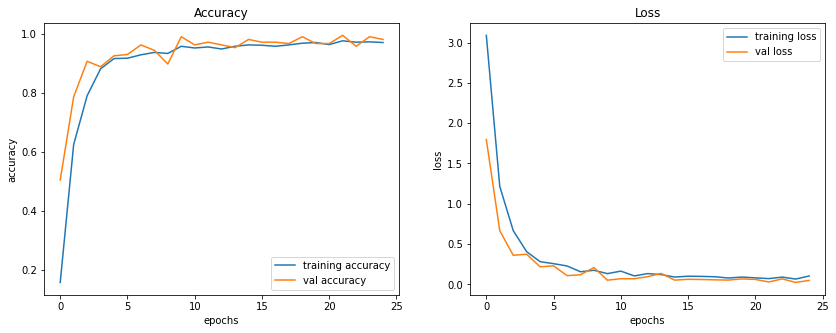

In [88]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

Save the model weights for future use.

In [89]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

Since we saved only the model weights, we first need to create a model instance and then load the saved weights into the model.

In [90]:
# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('checkpoints/my_checkpoint')

## Predict the license plate number


In [91]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  


In [98]:
def show_results(count):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = loaded_model.predict(img)[0] #predicting the class
        y_ = [i for i,x in enumerate(y_) if x == 1][0]
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number


1/1 [==============================] - 0s 23ms/step


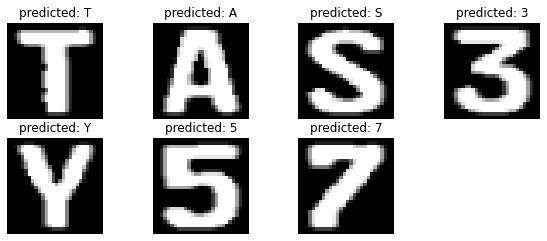

In [99]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results(count)[i]}')
    plt.axis('off')
#plt.show(count)

## Accuracy
We now need to run the whole code for all the images and calculate the accuracy.

In [100]:
pwd

'C:\\Users\\WIN10\\LPD'

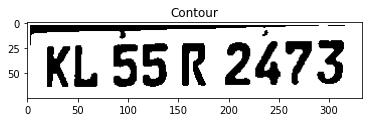

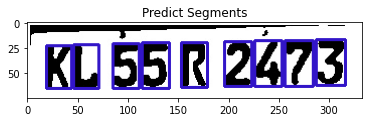

1/1 [==============================] - 0s 23ms/step


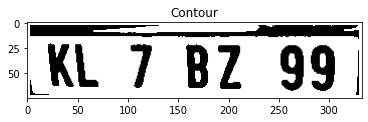

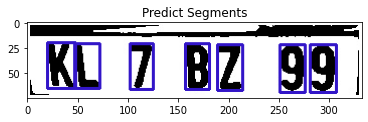

1/1 [==============================] - 0s 22ms/step
KL7BZ99
10.jpg


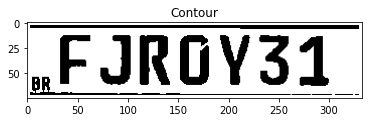

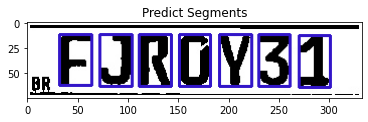

1/1 [==============================] - 0s 23ms/step
FJRDY31
100.JPG


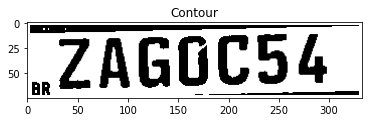

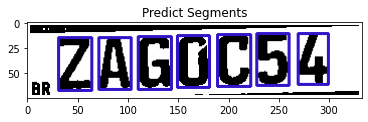

1/1 [==============================] - 0s 23ms/step


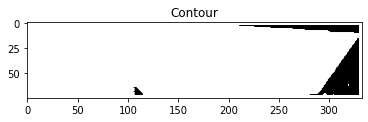


104.JPG


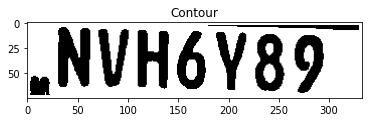

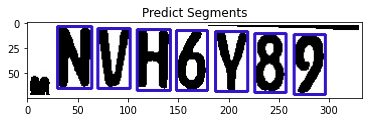

1/1 [==============================] - 0s 23ms/step
NVH6Y89
105.JPG


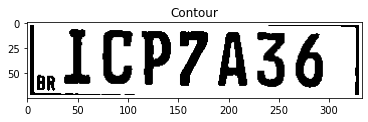

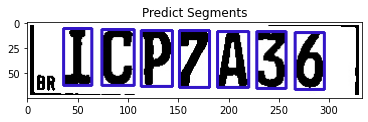

1/1 [==============================] - 0s 23ms/step
1CP7A36
108.JPG


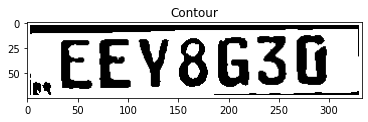

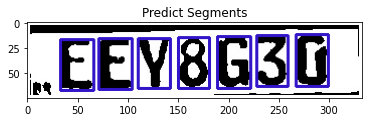

1/1 [==============================] - 0s 23ms/step
EEY8G30
109.JPG


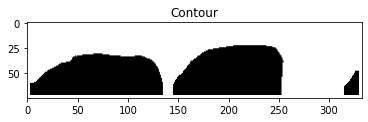


11.JPG


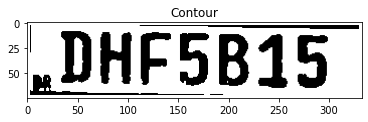

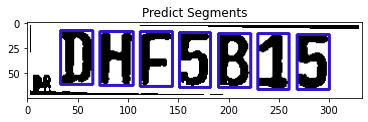

1/1 [==============================] - 0s 22ms/step
DHF5B15
110.JPG


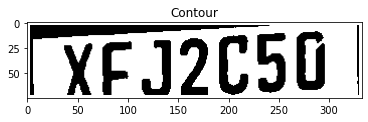

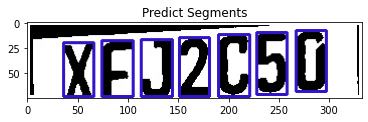

1/1 [==============================] - 0s 22ms/step
XFJ2C5D
112.JPG


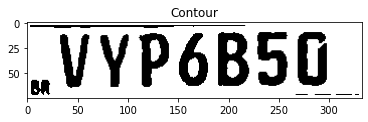

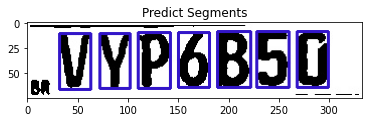

1/1 [==============================] - 0s 24ms/step
VYP6B5D
113.JPG


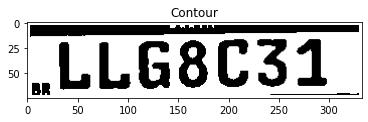

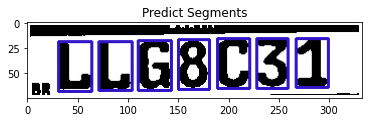

1/1 [==============================] - 0s 22ms/step
LLG8C31
114.JPG


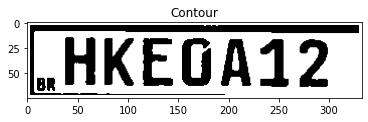

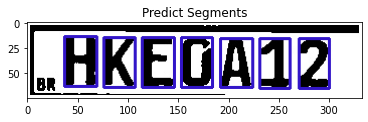

1/1 [==============================] - 0s 23ms/step
HKEDA12
116.JPG


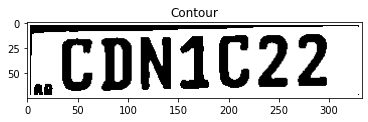

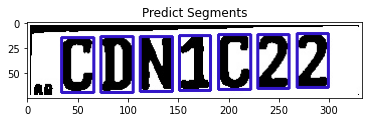

1/1 [==============================] - 0s 23ms/step
CDN1C22
117.JPG


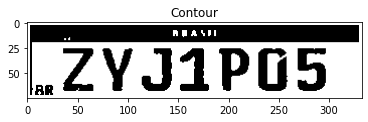

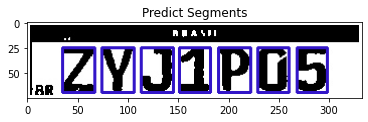

1/1 [==============================] - 0s 24ms/step
ZYJ1PD5
118.JPG


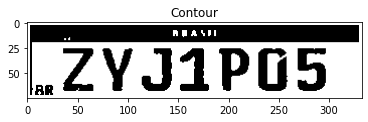

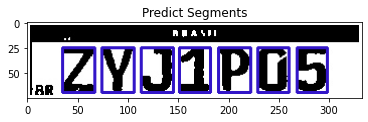

1/1 [==============================] - 0s 24ms/step
ZYJ1PD5
119.JPG


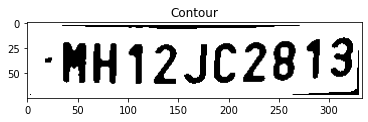

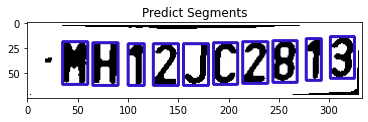

1/1 [==============================] - 0s 23ms/step


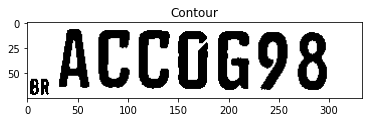

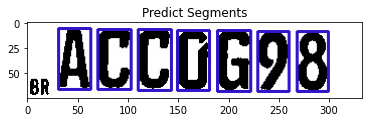

1/1 [==============================] - 0s 24ms/step
ACCDG98
120.JPG


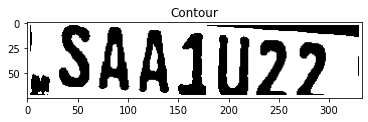

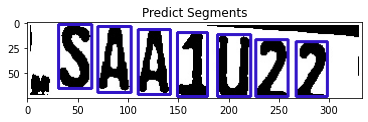

1/1 [==============================] - 0s 25ms/step
3AA1L27
121.JPG


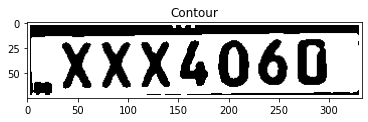

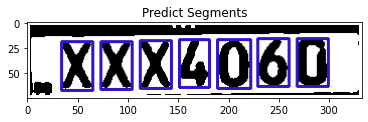

1/1 [==============================] - 0s 22ms/step
XXX4060
122.JPG


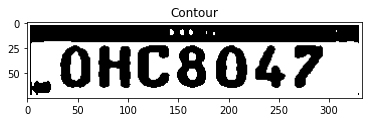

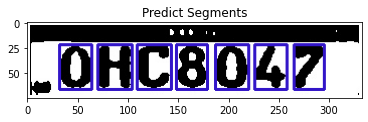

1/1 [==============================] - 0s 24ms/step
0HC8047
123.JPG


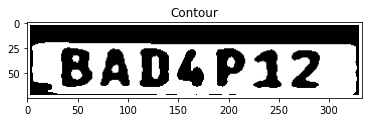

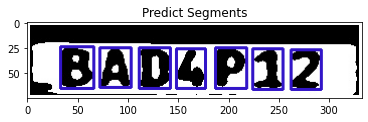

1/1 [==============================] - 0s 23ms/step
BAD4P12
125.JPG


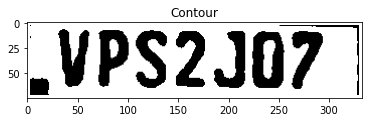

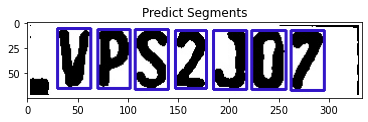

1/1 [==============================] - 0s 23ms/step
VPS2J07
126.JPG


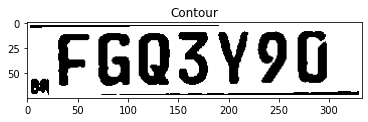

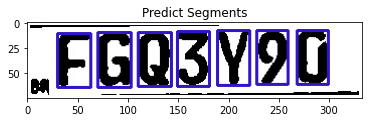

1/1 [==============================] - 0s 23ms/step
FGD3Y9U
127.JPG


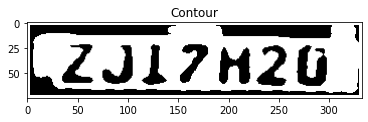

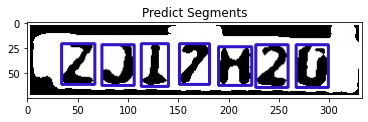

1/1 [==============================] - 0s 23ms/step
ZJ17H2U
128.JPG


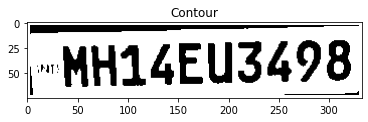

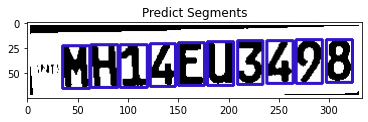

1/1 [==============================] - 0s 23ms/step
3H14EU3498
13.jpg


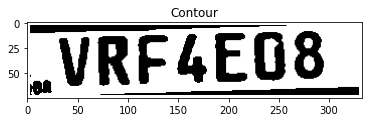

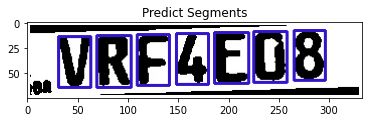

1/1 [==============================] - 0s 23ms/step
VRFAE08
130.JPG


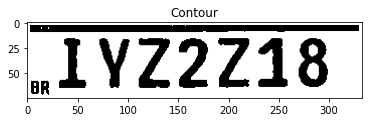

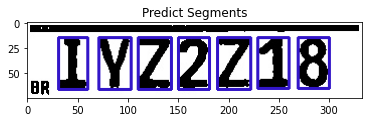

1/1 [==============================] - 0s 24ms/step
1YZ2Z18
131.JPG


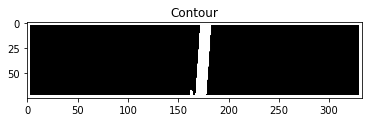


133.JPG


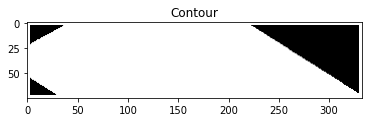


134.JPG


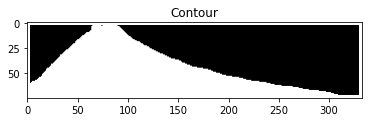


135.JPG


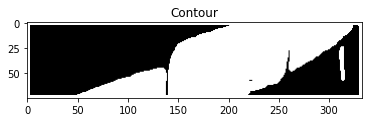


137.JPG


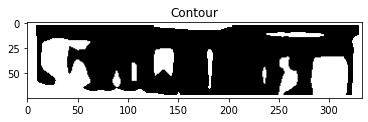


138.JPG


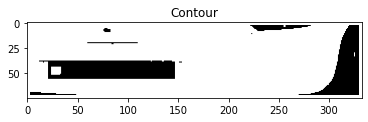


139.JPG


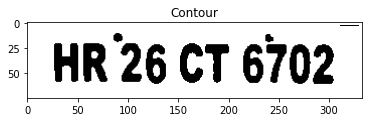

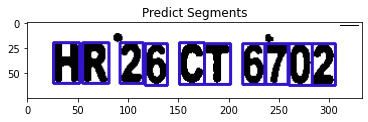

1/1 [==============================] - 0s 23ms/step


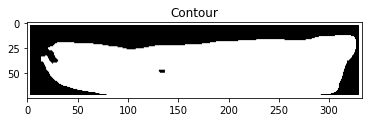


140.JPG


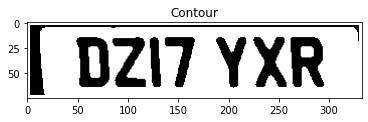

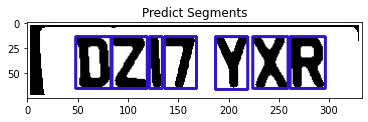

1/1 [==============================] - 0s 24ms/step
DZ17YXR
141.png


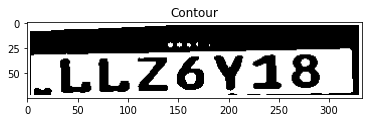

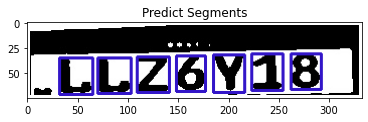

1/1 [==============================] - 0s 22ms/step
LLZ6Y18
143.JPG


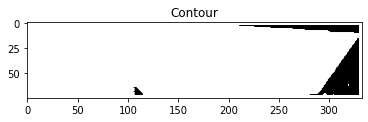


144.JPG


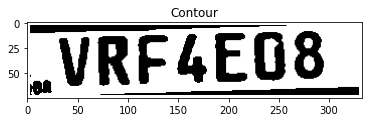

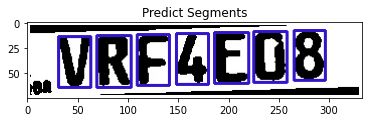

1/1 [==============================] - 0s 23ms/step
VRFAE08
146.JPG


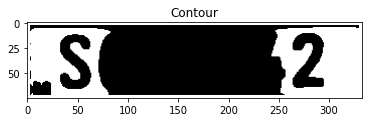

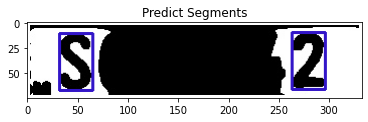

1/1 [==============================] - 0s 23ms/step
S2
148.JPG


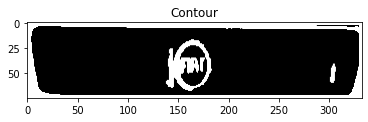

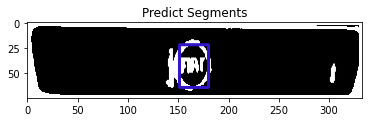

1/1 [==============================] - 0s 23ms/step


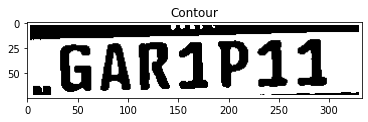

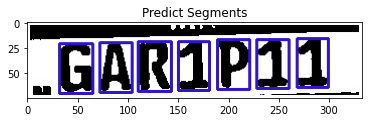

1/1 [==============================] - 0s 22ms/step
GAR1P11
15.JPG


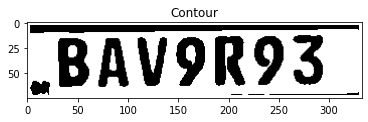

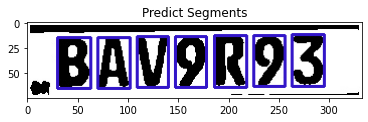

1/1 [==============================] - 0s 24ms/step
BAV9R93
150.JPG


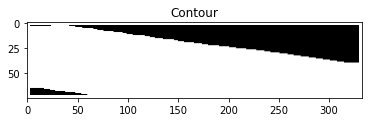


151.JPG


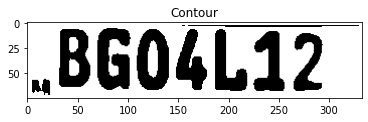

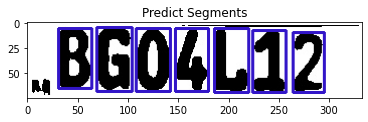

1/1 [==============================] - 0s 23ms/step
B804L12
152.JPG


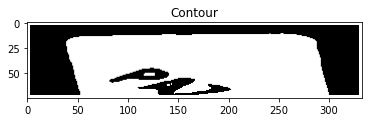


153.JPG


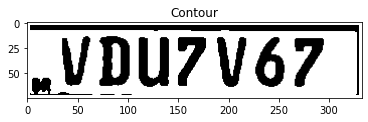

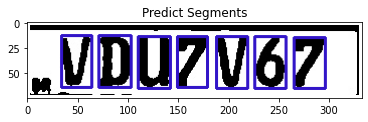

1/1 [==============================] - 0s 23ms/step
VDU7V67
154.JPG


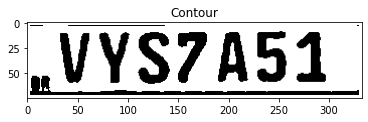

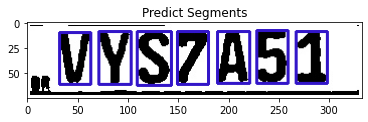

1/1 [==============================] - 0s 23ms/step
VYS7A51
156.JPG


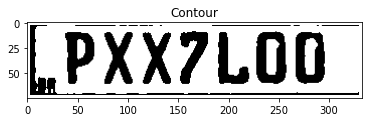

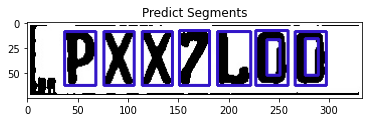

1/1 [==============================] - 0s 23ms/step
PXX7LDJ0U
157.JPG


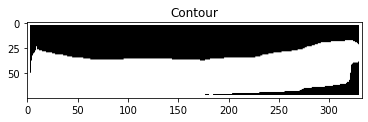


158.JPG


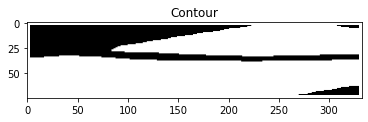


159.JPG


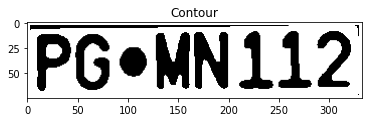

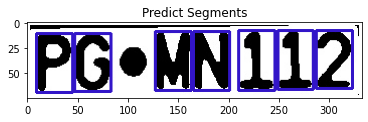

1/1 [==============================] - 0s 22ms/step


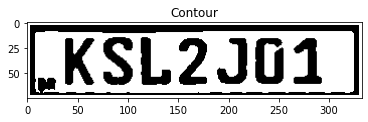

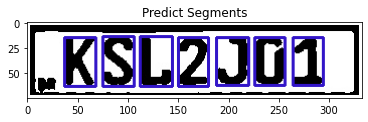

1/1 [==============================] - 0s 23ms/step
KSL2JD1
160.JPG


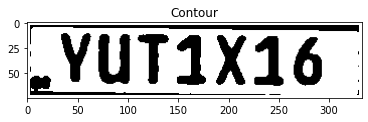

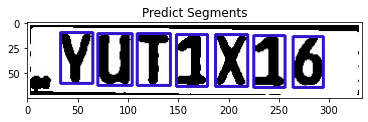

1/1 [==============================] - 0s 22ms/step
YUT1X16
161.JPG


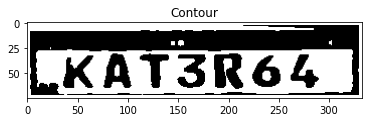

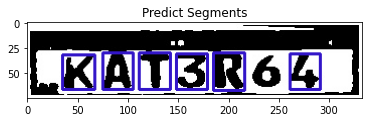

1/1 [==============================] - 0s 23ms/step
KAT3RL
162.JPG


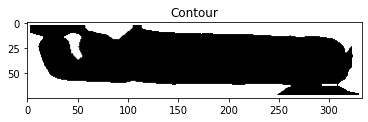


163.JPG


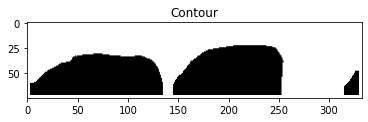


164.JPG


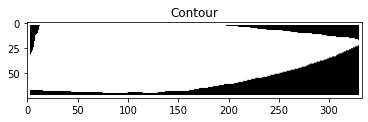


166.JPG


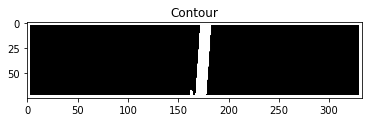


167.JPG


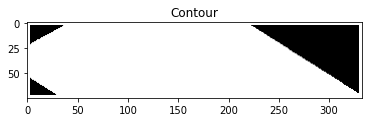


168.JPG


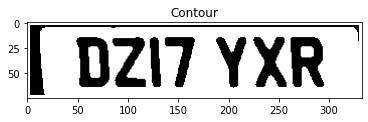

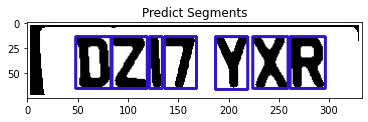

1/1 [==============================] - 0s 24ms/step
DZ17YXR
17.png


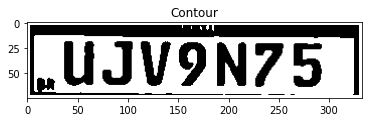

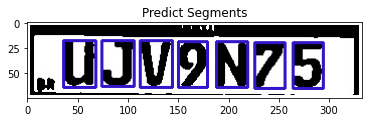

1/1 [==============================] - 0s 22ms/step
UJV9N75
170.JPG


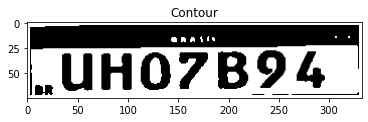

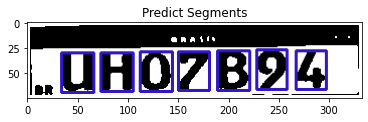

1/1 [==============================] - 0s 23ms/step
UH07B94
171.JPG


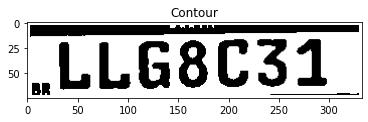

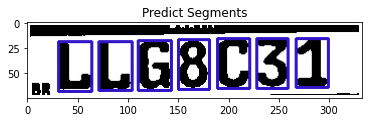

1/1 [==============================] - 0s 23ms/step
LLG8C31
172.JPG


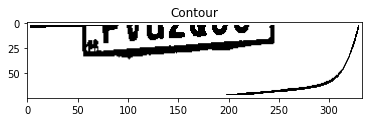


173.JPG


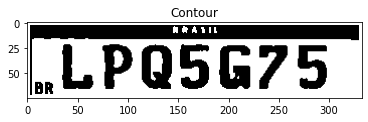

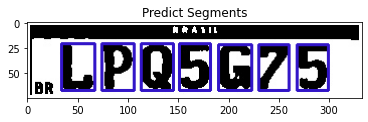

1/1 [==============================] - 0s 23ms/step
LP95875
174.JPG


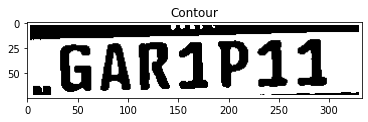

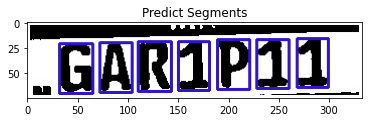

1/1 [==============================] - 0s 24ms/step
GAR1P11
175.JPG


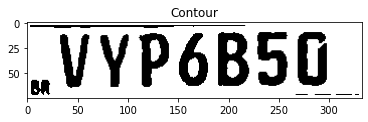

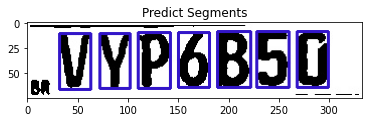

1/1 [==============================] - 0s 22ms/step
VYP6B5D
176.JPG


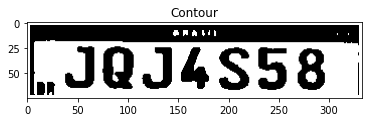

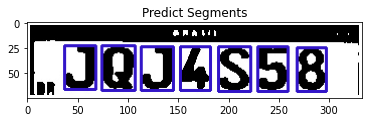

1/1 [==============================] - 0s 23ms/step
JDJ4SS8
177.JPG


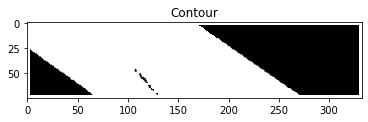


178.JPG


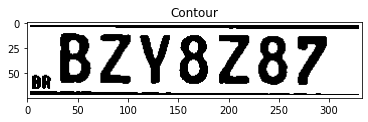

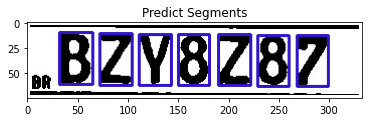

1/1 [==============================] - 0s 23ms/step
BZY8Z87
179.JPG


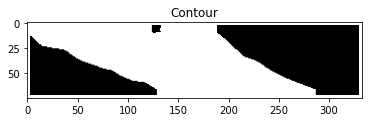


18.JPG


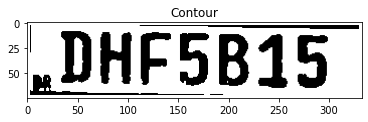

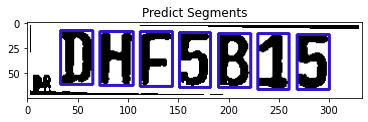

1/1 [==============================] - 0s 22ms/step
DHF5B15
182.JPG


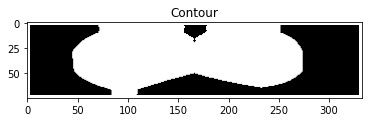


183.JPG


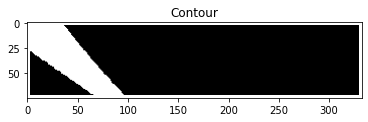


185.JPG


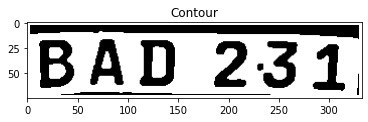

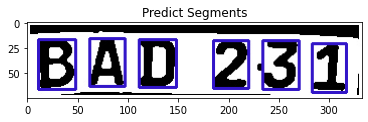

1/1 [==============================] - 0s 23ms/step
BAD231
19.png


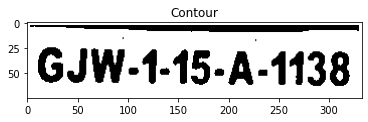

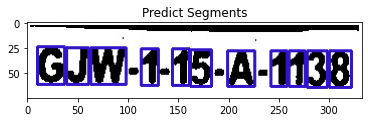

1/1 [==============================] - 0s 24ms/step


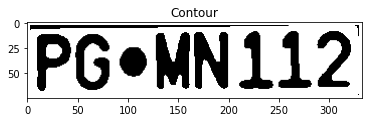

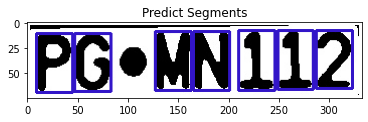

1/1 [==============================] - 0s 23ms/step


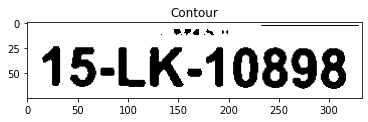

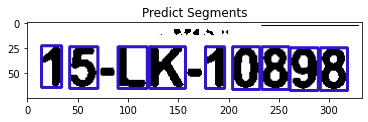

1/1 [==============================] - 0s 23ms/step
15LK10898
21.png


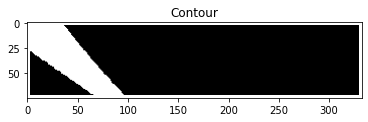


22.JPG


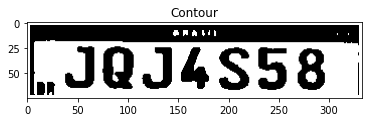

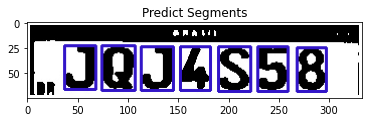

1/1 [==============================] - 0s 23ms/step
JDJ4SS8
24.JPG


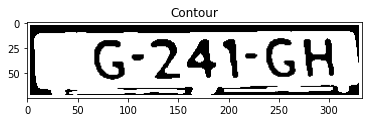

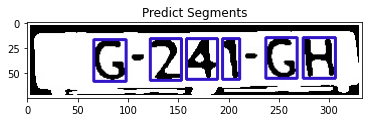

1/1 [==============================] - 0s 24ms/step
G241GH
25.jpg


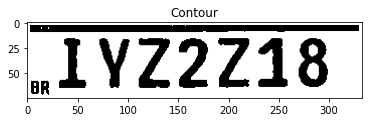

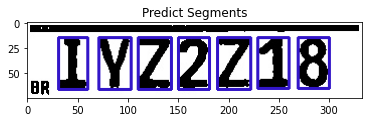

1/1 [==============================] - 0s 23ms/step
1YZ2Z18
27.JPG


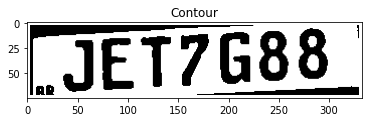

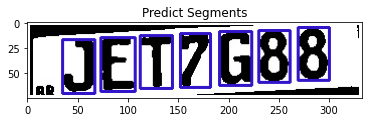

1/1 [==============================] - 0s 23ms/step
JET7G88
28.JPG


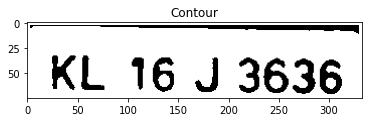

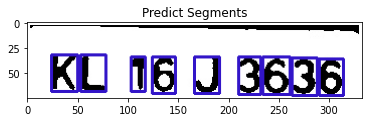

1/1 [==============================] - 0s 23ms/step
KL16J3636
3.jpg


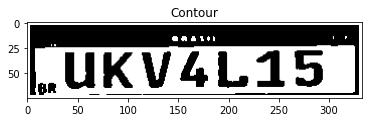

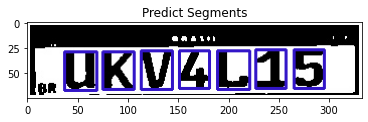

1/1 [==============================] - 0s 23ms/step
UKV4L15
30.JPG


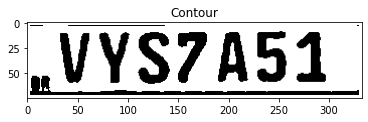

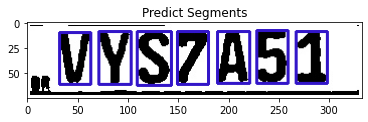

1/1 [==============================] - 0s 22ms/step
VYS7A51
31.JPG


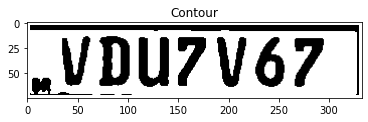

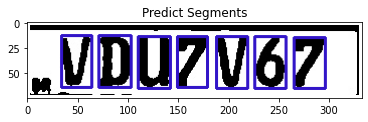

1/1 [==============================] - 0s 24ms/step
VDU7V67
32.JPG


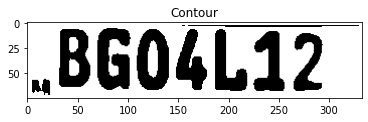

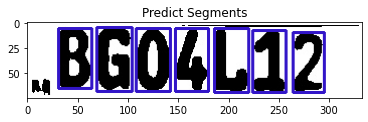

1/1 [==============================] - 0s 23ms/step
B804L12
33.JPG


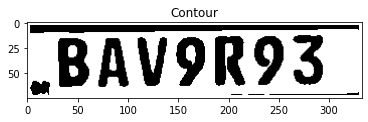

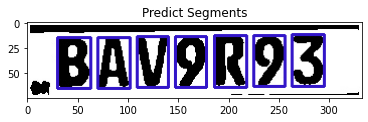

1/1 [==============================] - 0s 23ms/step
BAV9R93
34.JPG


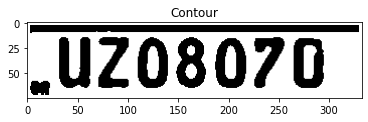

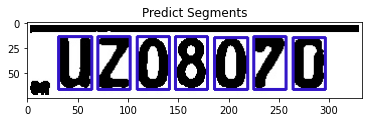

1/1 [==============================] - 0s 23ms/step
UZ0807D
35.JPG


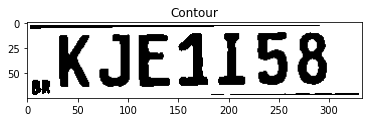

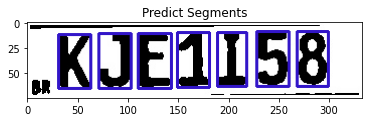

1/1 [==============================] - 0s 23ms/step
KJE1158
36.JPG


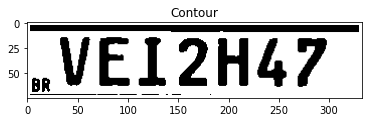

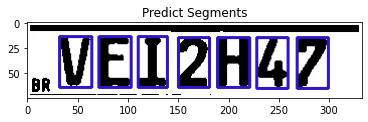

1/1 [==============================] - 0s 22ms/step
VE12H47
37.JPG


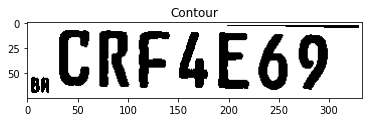

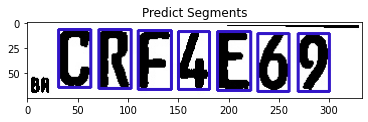

1/1 [==============================] - 0s 23ms/step
CRF4E69
38.JPG


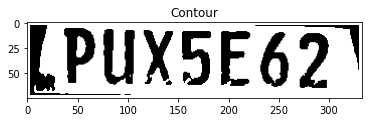

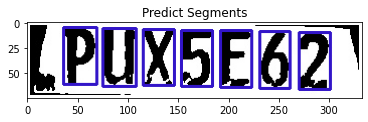

1/1 [==============================] - 0s 22ms/step
PUX5E62
39.JPG


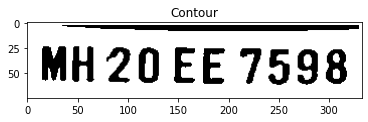

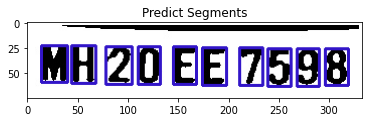

1/1 [==============================] - 0s 22ms/step
MH2DEE7598
4.jpg


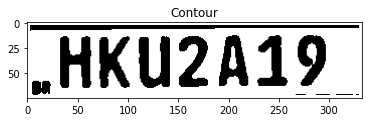

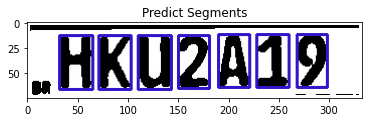

1/1 [==============================] - 0s 23ms/step
HKU2A19
42.JPG


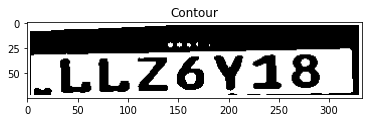

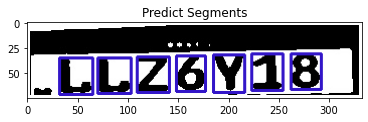

1/1 [==============================] - 0s 24ms/step
LLZ6Y18
44.JPG


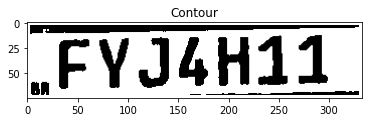

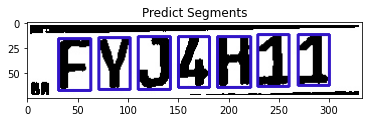

1/1 [==============================] - 0s 24ms/step
FYJ4H11
46.JPG


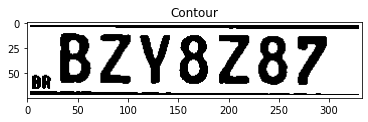

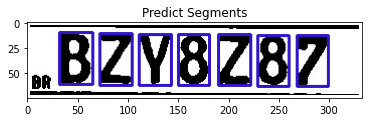

1/1 [==============================] - 0s 23ms/step
BZY8Z87
47.JPG


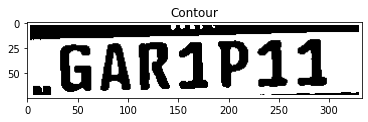

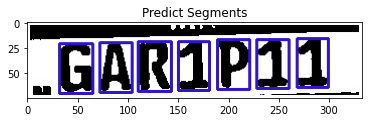

1/1 [==============================] - 0s 23ms/step
GAR1P11
48.JPG


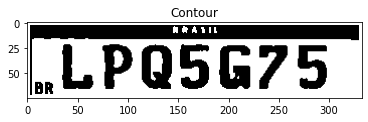

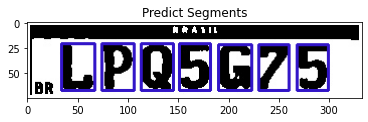

1/1 [==============================] - 0s 23ms/step
LP95875
49.JPG


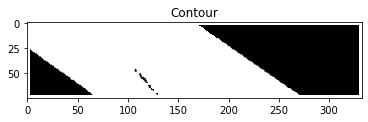


5.JPG


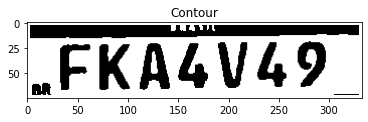

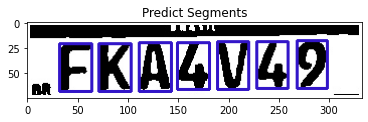

1/1 [==============================] - 0s 23ms/step
FKA4VL9
50.JPG


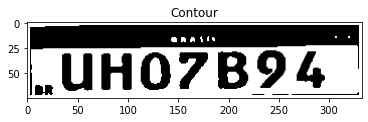

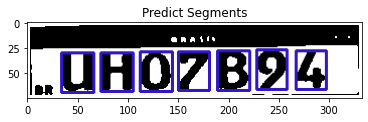

1/1 [==============================] - 0s 24ms/step
UH07B94
51.JPG


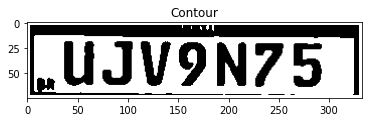

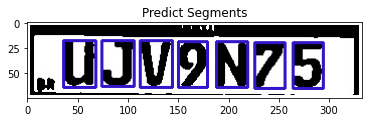

1/1 [==============================] - 0s 23ms/step
UJV9N75
52.JPG


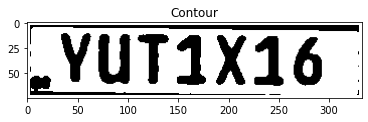

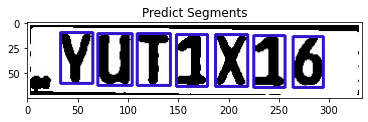

1/1 [==============================] - 0s 23ms/step
YUT1X16
54.JPG


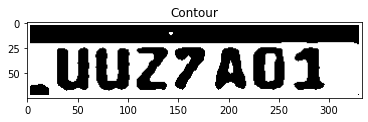

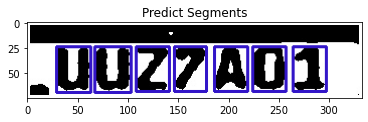

1/1 [==============================] - 0s 25ms/step
UUZ7A01
55.JPG


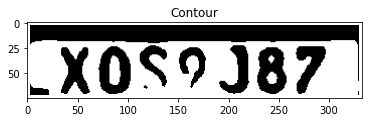

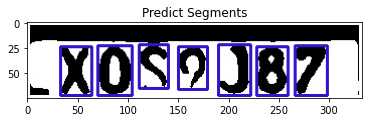

1/1 [==============================] - 0s 22ms/step
X0S9J87
56.JPG


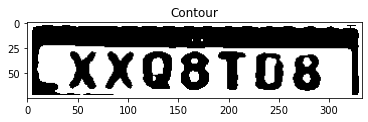

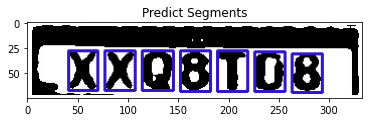

1/1 [==============================] - 0s 23ms/step
XXD8TD8
57.JPG


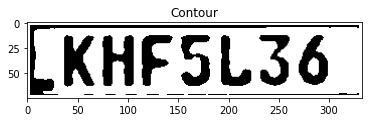

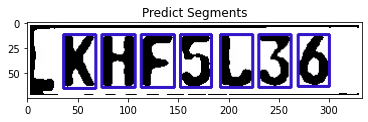

1/1 [==============================] - 0s 23ms/step
KHF3L36
58.JPG


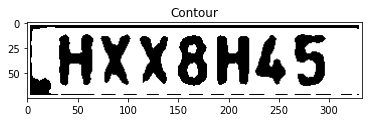

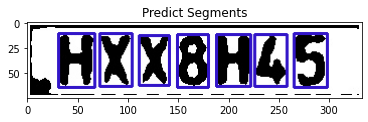

1/1 [==============================] - 0s 23ms/step
HXX8H45
59.JPG


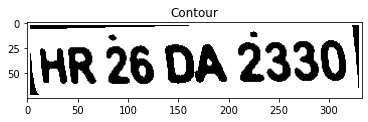

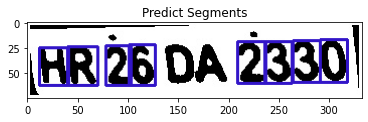

1/1 [==============================] - 0s 23ms/step
3R262330
6.jpg


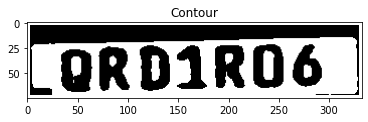

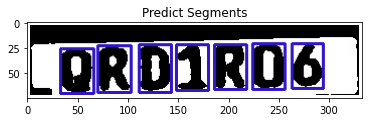

1/1 [==============================] - 0s 23ms/step
9RD1R06
60.JPG


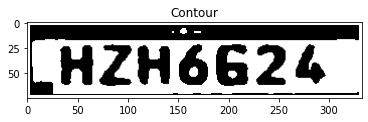

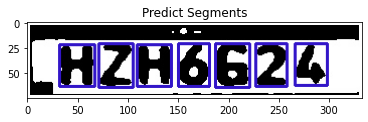

1/1 [==============================] - 0s 23ms/step
MZH682A
61.JPG


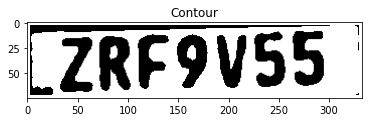

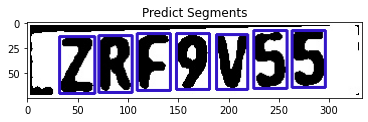

1/1 [==============================] - 0s 23ms/step
ZRF9VS5
62.JPG


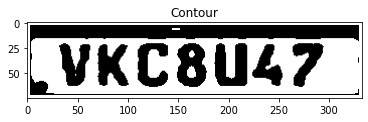

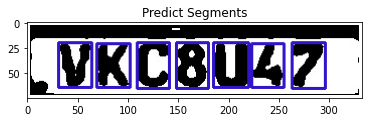

1/1 [==============================] - 0s 24ms/step
VKC8U47
63.JPG


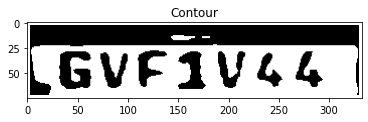

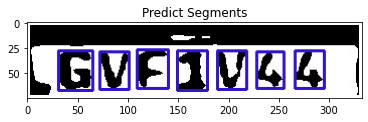

1/1 [==============================] - 0s 23ms/step


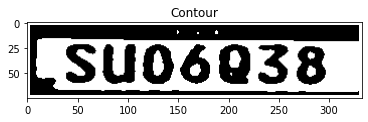

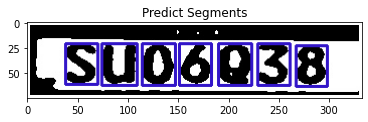

1/1 [==============================] - 0s 22ms/step
SU06938
66.JPG


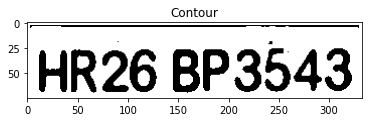

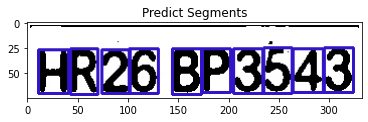

1/1 [==============================] - 0s 22ms/step
HR26BP3543
7.jpg


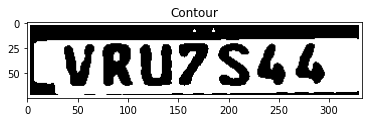

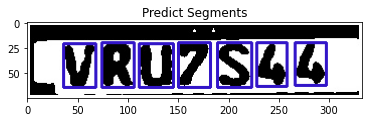

1/1 [==============================] - 0s 22ms/step
VRU7S4L
70.JPG


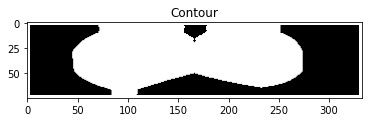


71.JPG


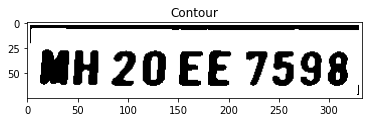

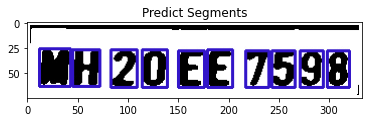

1/1 [==============================] - 0s 23ms/step
MH20EE7598
72.jpg


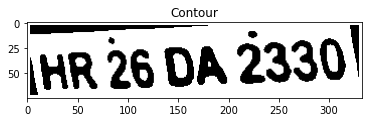

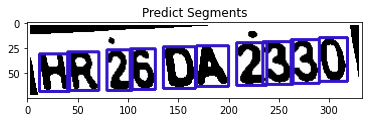

1/1 [==============================] - 0s 23ms/step
WA26DA2330
73.jpg


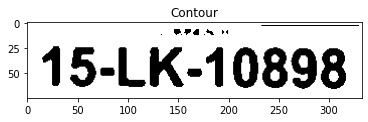

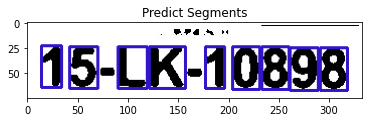

1/1 [==============================] - 0s 24ms/step
15LK10898
74.jpg


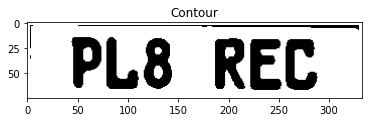

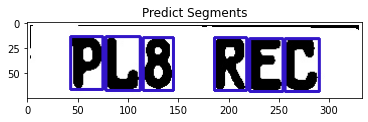

1/1 [==============================] - 0s 23ms/step
PL8RED
75.jpg


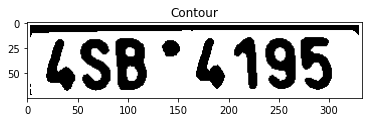

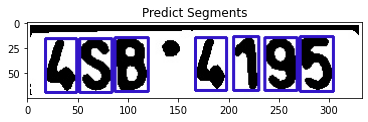

1/1 [==============================] - 0s 22ms/step
LSBL195
77.jpg


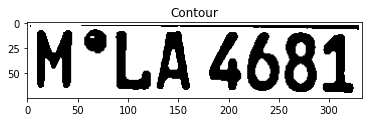

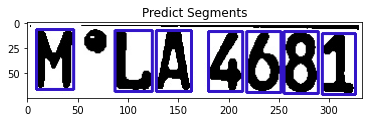

1/1 [==============================] - 0s 23ms/step
MLA4681
78.jpg


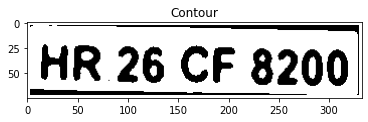

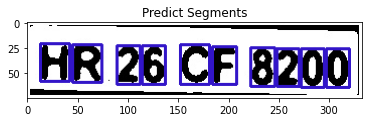

1/1 [==============================] - 0s 23ms/step


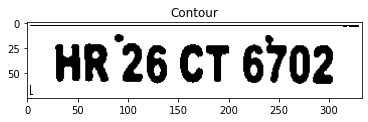

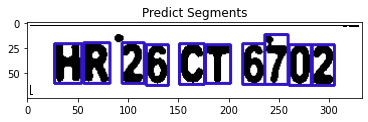

1/1 [==============================] - 0s 22ms/step
MR26CT6702
8.jpg


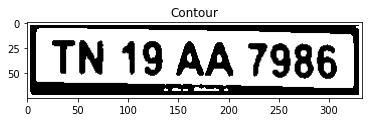

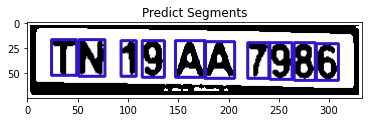

1/1 [==============================] - 0s 22ms/step
TN19AA7986
80.jpg


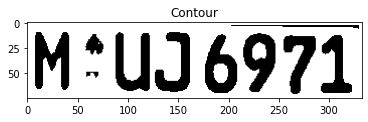

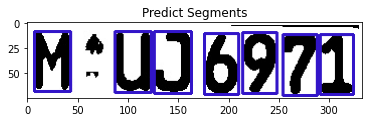

1/1 [==============================] - 0s 23ms/step
MUJ6971
81.jpg


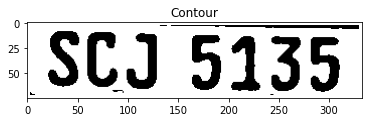

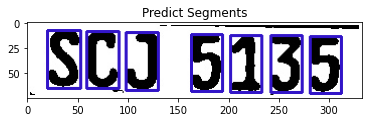

1/1 [==============================] - 0s 23ms/step
SCJ5135
82.jpg


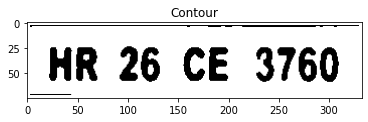

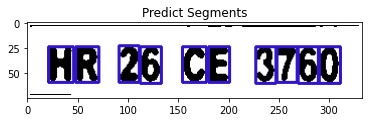

1/1 [==============================] - 0s 23ms/step
MR26CE3760
83.jpg


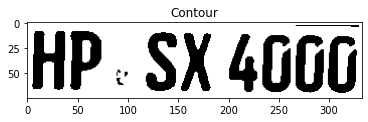

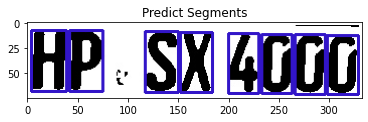

1/1 [==============================] - 0s 23ms/step


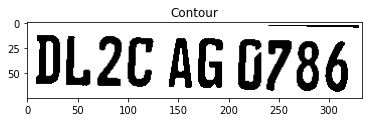

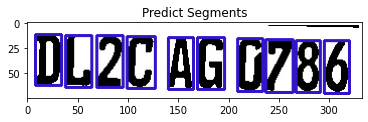

1/1 [==============================] - 0s 22ms/step


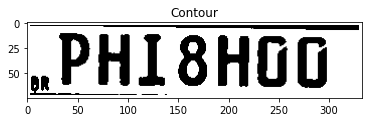

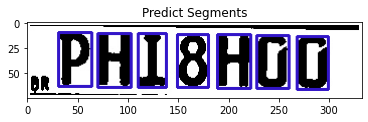

1/1 [==============================] - 0s 23ms/step
PH18HDD
86.JPG


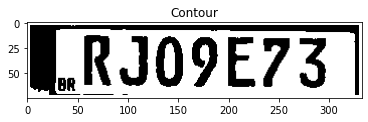

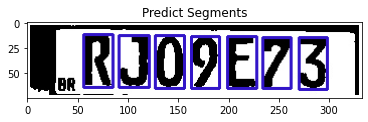

1/1 [==============================] - 0s 24ms/step
RJ09E73
87.JPG


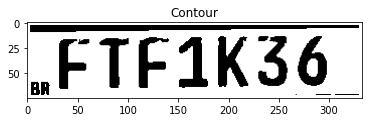

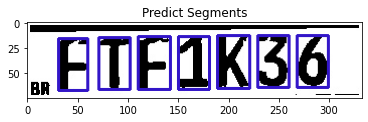

1/1 [==============================] - 0s 23ms/step
FTF1K36
88.JPG


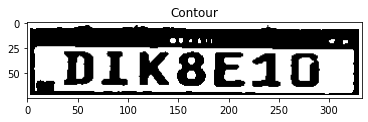

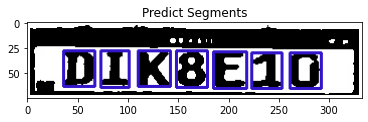

1/1 [==============================] - 0s 22ms/step
D1K8E10
89.JPG


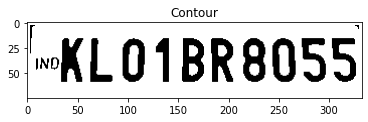

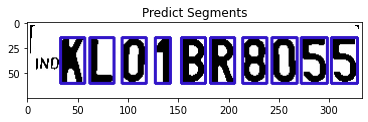

1/1 [==============================] - 0s 24ms/step
KL018R8055
9.jpg


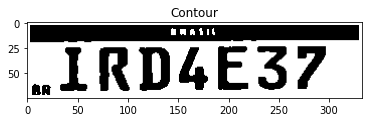

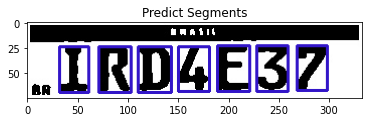

1/1 [==============================] - 0s 26ms/step
1RD4E37
90.JPG


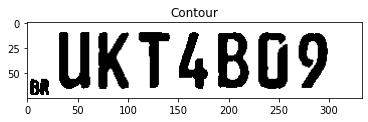

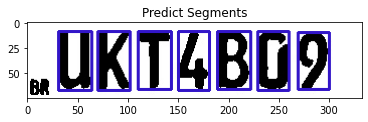

1/1 [==============================] - 0s 23ms/step
UKT4BD9
91.JPG


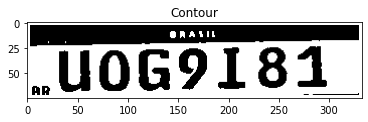

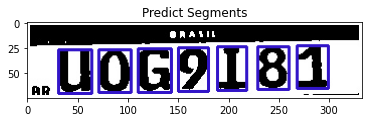

1/1 [==============================] - 0s 22ms/step
U0G9181
92.JPG


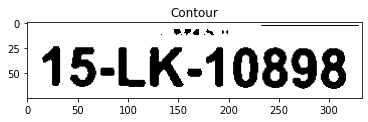

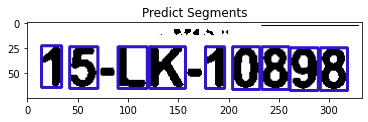

1/1 [==============================] - 0s 24ms/step
15LK10898
94.png


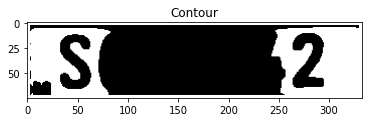

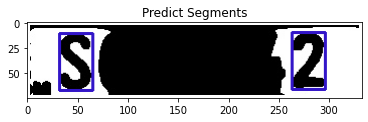

1/1 [==============================] - 0s 23ms/step
S2
95.JPG


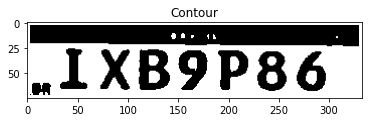

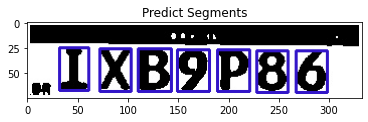

1/1 [==============================] - 0s 25ms/step
1XB9P86
96.JPG


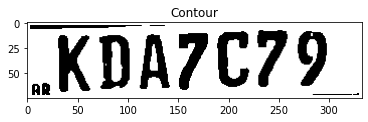

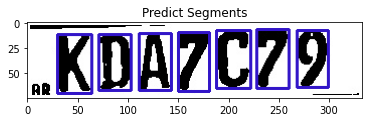

1/1 [==============================] - 0s 23ms/step
KDA7C79
98.JPG


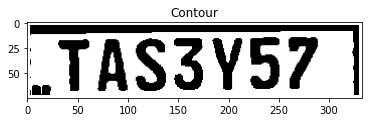

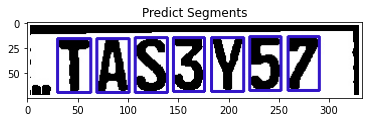

1/1 [==============================] - 0s 22ms/step
TAS3Y57
99.JPG
KL7BZ99 FJRDY31  NVH6Y89 1CP7A36 EEY8G30  DHF5B15 XFJ2C5D VYP6B5D LLG8C31 HKEDA12 CDN1C22 ZYJ1PD5 ZYJ1PD5 ACCDG98 3AA1L27 XXX4060 0HC8047 BAD4P12 VPS2J07 FGD3Y9U ZJ17H2U 3H14EU3498 VRFAE08 1YZ2Z18        DZ17YXR LLZ6Y18  VRFAE08 S2 GAR1P11 BAV9R93  B804L12  VDU7V67 VYS7A51 PXX7LDJ0U   KSL2JD1 YUT1X16 KAT3RL      DZ17YXR UJV9N75 UH07B94 LLG8C31  LP95875 GAR1P11 VYP6B5D JDJ4SS8  BZY8Z87  DHF5B15   BAD231 15LK10898  JDJ4SS8 G241GH 1YZ2Z18 JET7G88 KL16J3636 UKV4L15 VYS7A51 VDU7V67 B804L12 BAV9R93 UZ0807D KJE1158 VE12H47 CRF4E69 PUX5E62 MH2DEE7598 HKU2A19 LLZ6Y18 FYJ4H11 BZY8Z87 GAR1P11 LP95875  FKA4VL9 UH07B94 UJV9N75 YUT1X16 UUZ7A01 X0S9J87 XXD8TD8 KHF3L36 HXX8H45 3R262330 9RD1R06 MZH682A ZRF9VS5 VKC8U47 SU06938 HR26BP3543 VRU7S4L  MH20EE7598 WA26DA2330 15LK10898 PL8RED LSBL195 MLA4681 MR26CT6702 TN19AA7986 MUJ6971 SCJ5135 MR26CE3760 PH18HDD RJ09E73 FTF1K36 D1K8E10 KL018R8055 1RD4E37 UKT4BD9 U0G9181 15LK10898 S2 1XB9P86 KD

In [106]:
file_list=os.listdir(r"test_dataset/images")
errors_count = 0
count=0
num=0
plate_list = []
for path in file_list:
    try:
        #no=path[:-4]
        #row=labels['NUMBER'].where(labels['ID'] == no).dropna().values[0]
        image = cv2.imread('test_dataset/images/'+path)
        # Resize the image - change width to 500
        image = imutils.resize(image, width=500)
        img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # RGB to Gray scale conversion
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Noise removal with iterative bilateral filter(removes noise while preserving edges)
        gray = cv2.bilateralFilter(gray, 11, 17, 17)

        # Find Edges of the grayscale image
        edged = cv2.Canny(gray, 170, 200)

        # Find contours based on Edges
        cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
        cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
        NumberPlateCnt = None #we currently have no Number plate contour

        # loop over our contours to find the best possible approximate contour of number plate
        for c in cnts:
                peri = cv2.arcLength(c, True)
                approx = cv2.approxPolyDP(c, 0.02 * peri, True)
                if len(approx) == 4:  # Select the contour with 4 corners
                    NumberPlateCnt = approx #This is our approx Number Plate Contour
                    x,y,w,h = cv2.boundingRect(c)
                    ROI = img[y:y+h, x:x+w]
                    break

        idx=0
        m=0
        if NumberPlateCnt is None:
            continue
        for i in range(4):
            if NumberPlateCnt[i][0][1]>m:
                idx=i
                m=NumberPlateCnt[i][0][1]
        if idx==0:
            pin=3
        else:
            pin=idx-1
        if idx==3:
            nin=0
        else:
            nin=idx+1

        p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
        n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

        if p>n:
            if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
                left=pin
                right=idx
            else:
                left=idx
                right=pin
            d=p
        else:
            if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
                left=nin
                right=idx
            else:
                left=idx
                right=nin
            d=n
        left_x=NumberPlateCnt[left][0][0]
        left_y=NumberPlateCnt[left][0][1]
        right_x=NumberPlateCnt[right][0][0]
        right_y=NumberPlateCnt[right][0][1]

        opp=right_y-left_y
        hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
        sin=opp/hyp
        theta=math.asin(sin)*57.2958

        image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
        result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

        if opp>0:
            h=result.shape[0]-opp//2
        else:
            h=result.shape[0]+opp//2

        result=result[0:h, :]
        char=segment_characters(result)
        count=show_results(count)
        print(count)
        print(path)
        plate_list.append(count)
    except:
        errors_count += 1
for items in plate_list:
    print(items,end=' ')
print(f"\n\n***** from {len(plate_list)} images, successed {len(plate_list) - errors_count} predictions")
print(f"\n**** accuracy according the results: {(1 - (errors_count / len(plate_list))) * 100}% ")